In [ ]:
#Setup!
!pip3 install torch torchvision torchaudio
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
!pip install kaggle
%matplotlib inline
from fastai.vision.all import *
from pathlib import Path
from fastai.callback.hook import *

In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Unzip all data in a local env
!unzip gdrive/My\ Drive/Colab_Dataset/Segmentation.zip

In [2]:
# Dataset
path = Path('/content/Segmentation')
path.ls()

(#6) [Path('/content/Segmentation/segmentation.csv'),Path('/content/Segmentation/masks'),Path('/content/Segmentation/images'),Path('/content/Segmentation/val.csv'),Path('/content/Segmentation/test.csv'),Path('/content/Segmentation/train.csv')]

In [3]:
img_path = path/'images/valid'; img_path.ls()

(#310) [Path('/content/Segmentation/images/valid/7623_F2_f000120.jpg'),Path('/content/Segmentation/images/valid/7482_F3_f000020.jpg'),Path('/content/Segmentation/images/valid/7482_F2_f000320.jpg'),Path('/content/Segmentation/images/valid/9894_Amniataba_caudivittatus_f000010.jpg'),Path('/content/Segmentation/images/valid/9866_acanthopagrus_and_caranx_f000200.jpg'),Path('/content/Segmentation/images/valid/9852_Lutjanus_russellii_EJP_f000010.jpg'),Path('/content/Segmentation/images/valid/9866_acanthopagrus_palmaris_f000440.jpg'),Path('/content/Segmentation/images/valid/9866_acanthopagrus_and_caranx_f000170.jpg'),Path('/content/Segmentation/images/valid/9898_Acanthopagrus_palmaris_f000010.jpg'),Path('/content/Segmentation/images/valid/9866_acanthopagrus_and_caranx_f000290.jpg')...]

In [4]:
labels = path/'masks/valid1'; labels.ls()

(#310) [Path('/content/Segmentation/masks/valid1/7623_F2_f000120.jpg'),Path('/content/Segmentation/masks/valid1/7482_F3_f000020.jpg'),Path('/content/Segmentation/masks/valid1/7482_F2_f000320.jpg'),Path('/content/Segmentation/masks/valid1/9894_Amniataba_caudivittatus_f000010.jpg'),Path('/content/Segmentation/masks/valid1/9866_acanthopagrus_and_caranx_f000200.jpg'),Path('/content/Segmentation/masks/valid1/9852_Lutjanus_russellii_EJP_f000010.jpg'),Path('/content/Segmentation/masks/valid1/9866_acanthopagrus_palmaris_f000440.jpg'),Path('/content/Segmentation/masks/valid1/9866_acanthopagrus_and_caranx_f000170.jpg'),Path('/content/Segmentation/masks/valid1/9898_Acanthopagrus_palmaris_f000010.jpg'),Path('/content/Segmentation/masks/valid1/9866_acanthopagrus_and_caranx_f000290.jpg')...]

Gotta use PILImage.create() and PILMaks.create() :) Stop wasting your time with open_image and open_mask

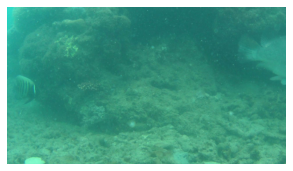

In [5]:
fnames = get_image_files(img_path)
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

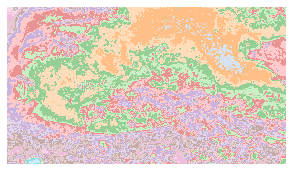

In [6]:
mask = PILMask.create(img_f)
mask.show(figsize=(5,5))

In [7]:
fnames = get_image_files(img_path)
labels_list = ['_'.join(x.name.split('_')) for x in fnames]
code_list = ['_'.join(x.name.split('_')[1:-1]) for x in fnames]

In [8]:
#code_list # Used to get the codes

In [9]:
#labels_list # To get an array of all files in img_path to create a txt file

In [10]:
codes = array(code_list, dtype='<U17')

In [11]:
codes

array(['F2', 'F3', 'F2', 'Amniataba_caudivi', 'acanthopagrus_and', 'Lutjanus_russelli', 'acanthopagrus_pal', 'acanthopagrus_and', 'Acanthopagrus_pal', 'acanthopagrus_and', 'Epinephelus', 'F2',
       'acanthopagrus_pal', 'Lutjanus_russelli', 'F6', 'Lutjanus_russelli', 'Lutjanus_argentim', 'Acanthopagrus_pal', 'F2', 'F6', 'F3', 'Lutjanus_argentim', 'acanthopagrus_pal', 'acanthopagrus_pal',
       'Acanthopagrus_pal', 'F4', 'Lutjanus_russelli', 'Acanthopagrus_pal', 'F2', 'F3', 'F2', 'acanthopagrus_and', 'F6', 'F2', 'F2', 'F3', 'F2', 'F2', 'F3', 'Acanthopagrus_pal', 'Epinephelus',
       'Epinephelus', 'F6', 'F3', 'F3', 'F2', 'F2', 'Acanthopagrus_pal', 'Acanthopagrus_pal', 'F4', 'F3', 'acanthopagrus_pal', 'Lutjanus_a_testcl', 'Epinephelus', 'acanthopagrus_and', 'F2',
       'Acanthopagrus_pal', 'F6', 'Acanthopagrus_pal', 'acanthopagrus_pal', 'F2', 'lutjanus_johnii', 'F6', 'F2', 'F3', 'acanthopagrus_pal', 'F3', 'acanthopagrus_and', 'Lutjanus_argentim', 'F2', 'F3',
       'acanthopagrus_and

In [12]:
get_msk = lambda o: labels/f'{o.stem}{o.suffix}'

In [13]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

## Datablock

In [14]:
sz = mask.shape; sz

(1080, 1920)

In [15]:
half = tuple(int(x/3) for x in sz); half

(360, 640)

In [16]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter('/content/valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [28]:
dls = camvid.dataloaders(img_path, bs=4)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
dls.train_ds.items[:310]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


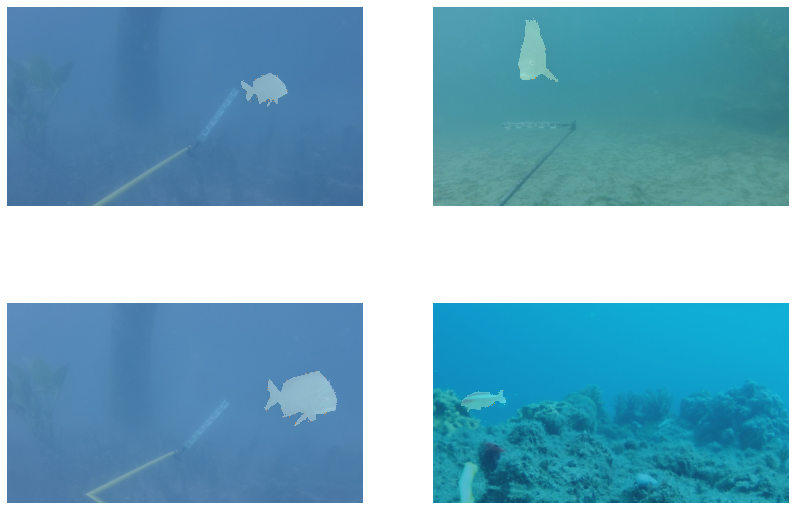

In [30]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

### Training

In [21]:
opt = ranger
dls.vocab = codes

In [22]:
name2id = {v:k for k,v in enumerate(codes)} 
name2id

{'Acanthopagrus_pal': 301,
 'Amniataba_caudivi': 213,
 'Caranx': 307,
 'Chaetodon_vagabun': 270,
 'Epinephelus': 277,
 'F1': 206,
 'F2': 306,
 'F3': 259,
 'F4': 309,
 'F6': 283,
 'Gerres': 287,
 'Lutjanus_a_testcl': 247,
 'Lutjanus_argentim': 303,
 'Lutjanus_russelli': 89,
 'acanthopagrus_and': 308,
 'acanthopagrus_pal': 292,
 'gerres': 267,
 'gerres_2': 264,
 'lutjanus_johnii': 236}

In most dataset there is a label called Void which we want to filter out. However since some part of the dataset is selfmade, I did not have to do it.

In [23]:
#void_code = name2id['F6']

In [24]:
#def acc_camvid(inp, targ):
#  targ = targ.squeeze(1)
#  mask = targ != void_code
#  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [25]:
learn = unet_learner(dls, resnet34, metrics=error_rate, self_attention=True, act_cls=Mish, opt_func=opt)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Minimum/10: 1.58e-03, steepest point: 1.58e-04


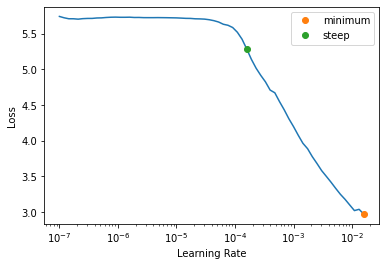

In [26]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn.lr_find()

In [27]:
learn.fit_flat_cos(3, slice(1.10e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.130605,None,None,01:13


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


KeyboardInterrupt: ignored

In [ ]:
learn.save('model_1')

Path('models/model_1.pth')

In [30]:
learn.show_results(max_n=4, figsize=(18,8))

ValueError: ignored

In [ ]:
dl = learn.dls.test_dl(fnames[:5])

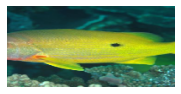

In [ ]:
dl.show_batch()

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 1000, 96, 200])

In [ ]:
len(codes)

1000

In [ ]:
pred_1 = preds[0][0]

In [ ]:
pred_1.shape

torch.Size([1000, 96, 200])

In [ ]:
pred_arx = pred_1.argmax(dim=0)

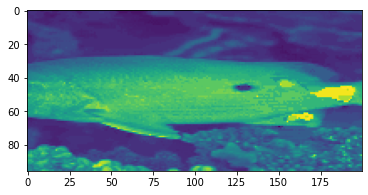

In [ ]:
plt.imshow(pred_arx)

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

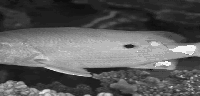

In [ ]:
im

In [ ]:
im.save('test.png')

In [ ]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.jpg')

In [ ]:
torch.save(preds[0][0], 'Image_1.pt')

In [ ]:
pred_1 = torch.load('Image_1.pt')

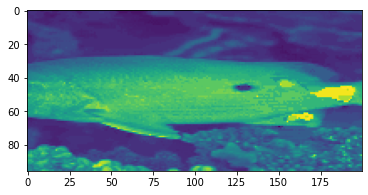

In [ ]:
plt.imshow(pred_1.argmax(dim=0))

## Restart training

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(path, bs=1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
opt = ranger

In [ ]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('model_1');

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0003981071640737355)

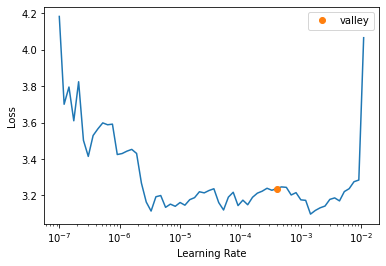

In [ ]:
learn.lr_find()

In [ ]:
lr = 0.0003981071640737355

In [ ]:
learn.fit_flat_cos(6, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,3.186122,3.426773,0.121016,07:20
1,3.178028,3.559202,0.126490,07:21
2,3.281243,3.639084,0.110889,07:21
3,3.294439,4.319728,0.145890,07:20
4,3.096800,11.442722,0.123587,07:21
5,3.084662,3.774204,0.144778,07:19


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save('full_1')

Path('models/full_1.pth')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 3.981071640737355e-05, None)

In [ ]:
learn.fit_flat_cos(6, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.311120,5.467807,0.156254,07:56
1,3.155925,7.167675,0.149299,07:59
2,3.055315,3.765427,0.178969,07:59
3,3.207633,5.205593,0.169356,08:00
4,3.221041,3.044521,0.174071,07:59
5,3.130975,6.835995,0.153626,07:59


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save('full_2')

Path('models/full_2.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


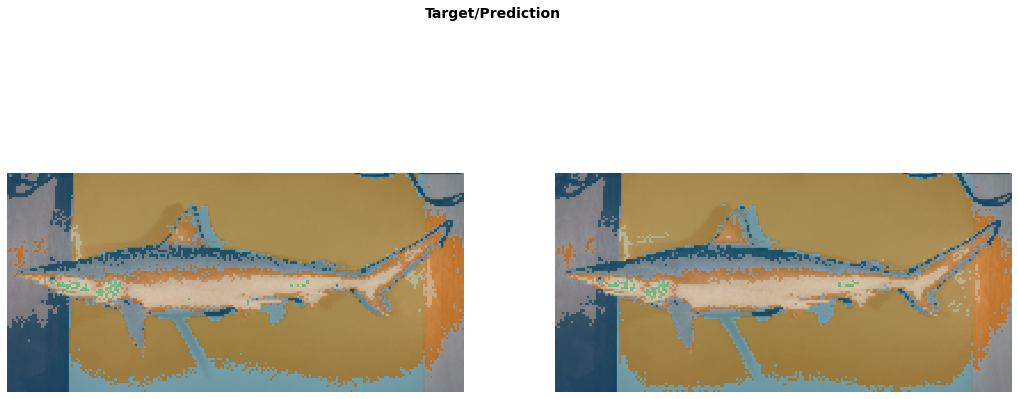

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

### Weighted Loss Functions


In [ ]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [ ]:
weights

In [ ]:
learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [ ]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [ ]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, loss_func=loss_func)

### Testing

In [ ]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [ ]:
def on_click(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(plt.imshow(img))

In [ ]:
btn_upload.observe(on_click, names=['data'])

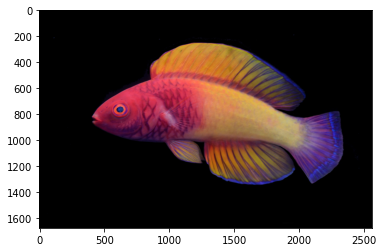

In [ ]:
display(VBox([widgets.Label('Select a image'), btn_upload, out_pl, lbl_pred]))